# Relatório Técnico: Pipeline ETL de Vendas com PySpark

## 1. Introdução
Este documento detalha o processo de Engenharia de Dados utilizado para processar, transformar e analisar o dataset de vendas da empresa. O objetivo é ingerir dados de fontes legadas (TXT posicional) e estruturadas (CSV), aplicar regras de negócio e fornecer insights estratégicos.

**Tecnologias:** Python 3.14, PySpark, Matplotlib.

In [1]:
import os
import shutil
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, DoubleType

# Configuração para gráficos aparecerem no notebook
%matplotlib inline

# Iniciar Sessão Spark
spark = SparkSession.builder \
    .appName("Analise_Notebook") \
    .getOrCreate()
    
spark.sparkContext.setLogLevel("WARN")
print("Sessão Spark iniciada com sucesso!")

Sessão Spark iniciada com sucesso!


## 2. Extração de Dados (Extract)
Nesta etapa, realizamos a leitura dos dados brutos.
* **Clientes:** Arquivo CSV com inferência de schema.
* **Vendas:** Arquivo posicional (Fixed Width), tratado com `substring`.

In [2]:
# Caminhos
path_clientes = "dados/clientes.csv"
path_vendas = "dados/vendas.txt"

# 1. Ler Clientes
clientes = spark.read.csv(path_clientes, header=True, inferSchema=True)

# 2. Ler Vendas (Lógica Posicional)
raw_vendas = spark.read.text(path_vendas)
vendas = raw_vendas.select(
    F.substring(F.col("value"), 1, 5).cast(IntegerType()).alias("venda_id"),
    F.substring(F.col("value"), 6, 5).cast(IntegerType()).alias("cliente_id"),
    F.substring(F.col("value"), 11, 5).cast(IntegerType()).alias("produto_id"),
    (F.substring(F.col("value"), 16, 8).cast(DoubleType()) / 100).alias("valor"),
    F.to_date(F.substring(F.col("value"), 24, 8), "yyyyMMdd").alias("data_venda")
)

print("Amostra de Clientes:")
clientes.show(5)

print("Amostra de Vendas (Processadas):")
vendas.show(5)

Amostra de Clientes:
+----------+-------+---------------+
|cliente_id|   nome|data_nascimento|
+----------+-------+---------------+
|         1|Suzanna|     2012-09-18|
|         2| Jazmin|     1959-09-13|
|         3|Melamie|     1967-07-05|
|         4| Vaughn|     2007-09-02|
|         5| Derrek|     1969-12-30|
+----------+-------+---------------+
only showing top 5 rows
Amostra de Vendas (Processadas):
+--------+----------+----------+-------+----------+
|venda_id|cliente_id|produto_id|  valor|data_venda|
+--------+----------+----------+-------+----------+
|       1|       527|       105|1392.11|2023-01-07|
|       2|       233|       119|1032.23|2023-03-16|
|       3|       655|       127| 502.79|2023-04-12|
|       4|       900|       143| 354.22|2023-06-30|
|       5|       112|       126|1021.65|2023-04-25|
+--------+----------+----------+-------+----------+
only showing top 5 rows


## 3. Transformação e Enriquecimento
Para gerar valor, não basta apenas cruzar dados. Portanto, criei novas features:
1. **Cálculo de Idade:** Baseado na data de nascimento.
2. **Faixa Etária:** Segmentação dos clientes para análise demográfica.

In [4]:
df_clientes = clientes.withColumn("idade", F.year(F.current_date()) - F.year(F.col("data_nascimento")))

clientes_faixa_etaria = df_clientes.withColumn("faixa_etaria", 
    F.when(F.col("idade") < 25, "Jovem (Até 24)")
     .when((F.col("idade") >= 25) & (F.col("idade") <= 45), "Adulto (25-45)")
     .otherwise("Sênior (46+)")
)

# Join com Vendas
df_completo = vendas.join(clientes_faixa_etaria, on="cliente_id", how="inner")

print("Schema Final dos Dados Enriquecidos:")
df_completo.printSchema()
df_completo.show(10)

Schema Final dos Dados Enriquecidos:
root
 |-- cliente_id: integer (nullable = true)
 |-- venda_id: integer (nullable = true)
 |-- produto_id: integer (nullable = true)
 |-- valor: double (nullable = true)
 |-- data_venda: date (nullable = true)
 |-- nome: string (nullable = true)
 |-- data_nascimento: date (nullable = true)
 |-- idade: integer (nullable = true)
 |-- faixa_etaria: string (nullable = false)

+----------+--------+----------+-------+----------+--------+---------------+-----+--------------+
|cliente_id|venda_id|produto_id|  valor|data_venda|    nome|data_nascimento|idade|  faixa_etaria|
+----------+--------+----------+-------+----------+--------+---------------+-----+--------------+
|       527|       1|       105|1392.11|2023-01-07|  Karlie|     1959-11-09|   66|  Sênior (46+)|
|       233|       2|       119|1032.23|2023-03-16|   Tildi|     2023-06-01|    2|Jovem (Até 24)|
|       655|       3|       127| 502.79|2023-04-12|   Ollie|     2010-11-21|   15|Jovem (Até 24)|
|

## 4. Análise de Dados e Visualização
Utilizamos os dados transformados para responder a perguntas de negócio.

### 4.1 Performance por Faixa Etária
Qual grupo demográfico traz mais receita?

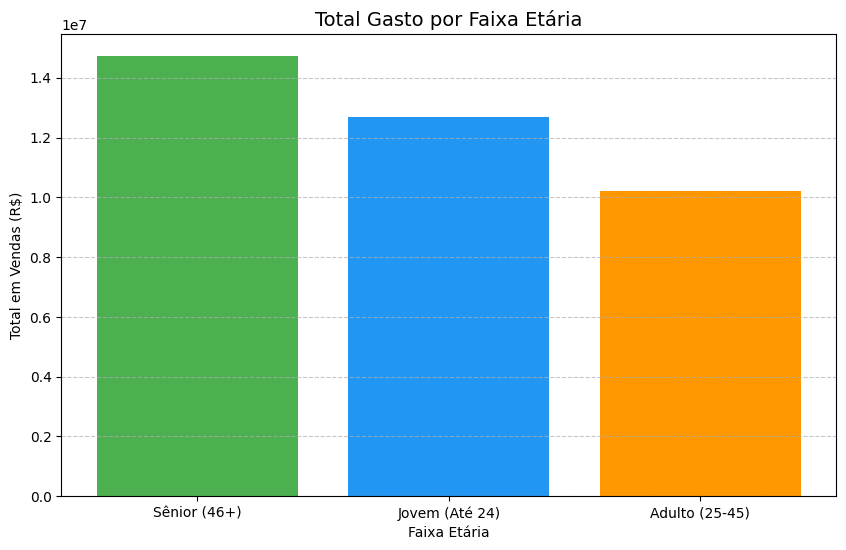

In [5]:
# Agregação via Spark
idade = df_completo.groupBy("faixa_etaria").agg(
    F.sum("valor").alias("total_gasto")
).orderBy(F.desc("total_gasto"))

grafico_idade = idade.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(grafico_idade['faixa_etaria'], grafico_idade['total_gasto'], color=['#4CAF50', '#2196F3', '#FF9800'])
plt.title('Total Gasto por Faixa Etária', fontsize=14)
plt.xlabel('Faixa Etária')
plt.ylabel('Total em Vendas (R$)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 4.2 Análise de Sazonalidade (Dia da Semana)

Qual dia da semana vendeu mais?

+----------+-----------------+
|dia_semana|     total_vendas|
+----------+-----------------+
|    Friday|5506710.030000001|
|  Thursday|5437627.219999999|
|   Tuesday|5425841.359999977|
|    Monday|5410185.410000014|
|    Sunday|5370961.220000002|
| Wednesday|5345566.129999994|
|  Saturday|5114374.159999991|
+----------+-----------------+



Text(0.5, 0, 'Dia da Semana')

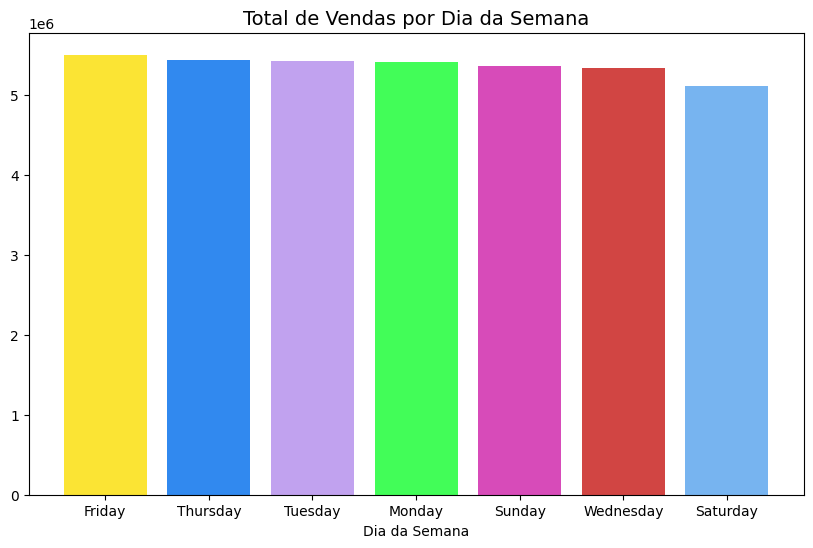

In [6]:
from pyspark.sql.functions import date_format

df_sazonalidade = df_completo.withColumn("dia_semana", date_format(F.col("data_venda"), "EEEE"))

vendas_por_dia = df_sazonalidade.groupBy("dia_semana").agg(
    F.sum("valor").alias("total_vendas")
).orderBy(F.desc("total_vendas"))

vendas_por_dia.show()

grafico_vendas = vendas_por_dia.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(grafico_vendas['dia_semana'], grafico_vendas['total_vendas'], color=["#FBE434", "#3189ef", "#C1A2EF",  "#42FD58", "#d74bb9", "#D14543", "#77b4f0"])
plt.title('Total de Vendas por Dia da Semana', fontsize=14)
plt.xlabel('Dia da Semana')

### 4.3 Clientes Inativos (Churn Risk)

Quais clientes que compraram no passado, mas estão há muito tempo sem comprar?

In [7]:
data_referencia = df_completo.agg(F.max("data_venda")).collect()[0][0]

df_recencia = df_completo.groupBy("cliente_id", "nome").agg(
    F.max("data_venda").alias("ultima_compra")
)

df_recencia = df_recencia.withColumn(
    "dias_inativo",
    F.datediff(F.lit(data_referencia), F.col("ultima_compra"))
)

clientes_inativos = df_recencia.filter(F.col("dias_inativo") > 90).orderBy(F.desc("dias_inativo"))
clientes_inativos.show(5)

+----------+----+-------------+------------+
|cliente_id|nome|ultima_compra|dias_inativo|
+----------+----+-------------+------------+
+----------+----+-------------+------------+



## 5. Carga e Particionamento (Load)
Para simular um ambiente de Data Lake, os dados finais não são salvos em um único arquivo, mas **particionados por data de venda**. Isso otimiza consultas futuras que filtrem por período.

In [8]:
import csv

def salvar_particionamento(df, pasta_raiz):
    if os.path.exists(pasta_raiz):
        shutil.rmtree(pasta_raiz)
    
    linhas = df.collect()
    colunas = df.columns
    idx_data = colunas.index("data_venda")

    buffer = {}
    for linha in linhas:
        data_venda = linha[idx_data].strftime("%Y-%m-%d")
        if data_venda not in buffer:
            buffer[data_venda] = []
        buffer[data_venda].append(linha)

    count_pastas = 0
    for data, dados in buffer.items():
        pasta = os.path.join(pasta_raiz, f"data_venda={data}")
        os.makedirs(pasta, exist_ok=True)        
        with open(os.path.join(pasta, "dados.csv"), 'w', newline='', encoding='utf-8') as f:
            csv.writer(f).writerow(colunas)
            csv.writer(f).writerow(dados)
        count_pastas += 1

    print(f"Dados salvos em {count_pastas} partições de data na pasta '{pasta_raiz}'.")

salvar_particionamento(df_completo, "output/vendas_detalhadas")


Dados salvos em 181 partições de data na pasta 'output/vendas_detalhadas'.
